# Импорт модулей и библиотек

In [1]:
import pandas as pd
import numpy as np
import pickle
import datetime as d
import matplotlib.pyplot as plt
import seaborn as sns
from math import log2

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

!pip install implicit
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender
from implicit.als import AlternatingLeastSquares
from implicit.lmf import LogisticMatrixFactorization
from implicit.bpr import BayesianPersonalizedRanking

!pip install lightfm 
from lightfm import LightFM

!pip install comet_ml
from comet_ml import Experiment

!pip install tqdm
from tqdm.notebook import tqdm, trange

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 66.6 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp39-cp39-linux_x86_64.whl size=875596 sha256=2689b5e2395a9f5b99f43ad96c86f6d12ae8a730426af03b402890696dab89c1
  Stored in directory: /root/.cache/pip/wheels/d8/65/93/6ac8180274dc2e8f86ff326be62da1dfa55dc158fd45faba7d
Successfully built lightfm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.6/484.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.9/505.9 kB 49.1

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Preprocessing

In [3]:
def extraction_data(path_new_data: str, all_years_df = pd.DataFrame([])):

    # load data 2015-2021 years
    for year in range(2015, 2022):
        with open(f"/content/gdrive/MyDrive/Colab Notebooks/Data/df_{year}_cleaned.pickle", "rb") as file:
            df_years = pickle.load(file)
        all_years_df = all_years_df.append(df_years, ignore_index=True)

    all_years_df.rename(columns={"deals": "amount"}, inplace=True)
    all_years_df.drop("date", axis=1, inplace=True)
    
    # load data 2022 years
    df_2022 = pd.read_csv(f"{path_new_data}", sep=";")

    # Some transforms for data 
    df_2022["datetime"] = pd.to_datetime(df_2022["timestamp"])
    df_2022["cf"] = -df_2022["amount"]*df_2022["price"]
    df_2022.rename(columns={"id": "user"}, inplace=True)

    df_2022 = df_2022.reindex(columns=["datetime", "ticker", "amount", "price", "user", "cf"])

    df_result = pd.concat([df_2022, all_years_df]).reset_index(drop = True)
    df_result["volume"] = abs(df_result["cf"])
    
    tick2ind = {ticker:i for i, ticker in enumerate(df_result.ticker.unique())}
    ind2tick = {val:key for key, val in tick2ind.items()}
    df_result["ticker_id"] = df_result["ticker"].apply(lambda x: tick2ind[x])

    user2ind = {user:i for i, user in enumerate(df_result.user.unique())}
    ind2user = {val:key for key, val in user2ind.items()}
    df_result["user_id"] = df_result["user"].apply(lambda x: user2ind[x])
    df_result.groupby(["ticker_id", "user_id", "datetime"], as_index=False)["volume"].sum()
    df_result["year"] = df_result["datetime"].apply(lambda row: row.year)
    
    df_result.sort_values("datetime", inplace = True)
    return df_result.reset_index(drop = True)

In [4]:
df_result = extraction_data("/content/gdrive/MyDrive/Colab Notebooks/Data/stock_market_trades.csv")

In [5]:
#df_result = pd.read_csv("../Data/Result_data/resultData.csv", index_col=0)
tick2ind = {ticker:i for i, ticker in enumerate(df_result.ticker.unique())}
ind2tick = {val:key for key, val in tick2ind.items()}
user2ind = {user:i for i, user in enumerate(df_result["user"].unique())}
ind2user = {val:key for key, val in user2ind.items()}
print(user2ind["1_95110"])

10729


In [6]:
df_result.head(5)

,datetime,ticker,amount,price,user,cf,volume,ticker_id,user_id,year
0,2015-09-16 10:00:00,LKOH,5,2485.10,1_48198,-12425.5,12425.5,4,8851,2015
1,2015-09-16 10:00:00,SBER,100,75.12,1_48199,-7512.0,7512.0,23,8951,2015
2,2015-09-16 10:00:00,SBER,10,75.25,1_49493,-752.5,752.5,23,3355,2015
3,2015-09-16 10:00:00,LKOH,38,2485.10,1_48198,-94433.8,94433.8,4,8851,2015
4,2015-09-16 10:00:00,SBER,-200,75.23,1_48670,15046.0,15046.0,23,7243,2015


## train-test-split

### Создаем словарь (Дата сделки: сделка)

In [7]:
def date_deals(df, data):    
    
    """
    Функция получает на вход столбец датафрейма с датами сделок
    
    На выходе: словарь с ключами - Дата сделки, а значения - сами сделки
    """
    
    date_deal = {}
    dates=set(data.values)
    
    for d in dates:
        deals = df[(data==d)]
        if len(deals)==1:
            continue
        else:
            date_deal[d] = deals    
            
    return date_deal

# Train_test_split

In [8]:
def train_test_split(df, train_size=0.7, test_size=0.3):
    
    train = pd.DataFrame()
    test = pd.DataFrame()
    dict_date = date_deals(df, df["year"])
    
    for key in dict_date.keys():
        deals_count = len(dict_date[key])
        to_train = round(deals_count*train_size)
        to_test = round(deals_count*test_size)
            
        train = pd.concat([train, dict_date[key][:to_train]])
        test = pd.concat([test, dict_date[key][-to_test:]])
    return (train, test)

In [9]:
%%time
train, test = train_test_split(df_result, train_size=0.7, test_size=0.3)

CPU times: user 1.19 s, sys: 241 ms, total: 1.43 s
Wall time: 1.41 s


# Сбор матриц

In [10]:
def get_csr_matrix(df, user_col, ticker_col, add_col, csr_method):
    n_rows = df[user_col].nunique()
    n_cols = df[ticker_col].nunique()

    row = df[user_col] #user
    col = df[ticker_col] #ticker
    data = df[add_col].astype(float) #deals
    
    return csr_method((data, (row, col)))

In [11]:
csr_train = get_csr_matrix(train, "user_id", "ticker_id", "volume", csr_matrix)
csr_test = get_csr_matrix(test, "user_id", "ticker_id", "volume", csr_matrix)

# Обучение

Параметр K влияет на максимальную выдачу топа, поэтому N для таких моделей желательно указывать меньше K

In [12]:
def recommend_tick(user, model, train_matrix, N):
    user_id = user2ind[user]

    recs = model.recommend(user_id, train_matrix[user_id], N=N, filter_already_liked_items=True)
    
    res = [ind2tick[ticker_ids] for ticker_ids in recs[0]]
    return res

In [13]:
def find_similar(user, model, train_matrix, N):
    user_id = user2ind[user]

    recs = model.recommend(user_id, train_matrix[user_id], N=N, filter_already_liked_items=True)
    
    res = recs[1]
    return res

In [14]:
def get_recommenders(model, csr_matrix_train, df_test, 
                     k=20, factors=40, regularization=0.1, iterations=20,
                     top_N = 10):
    
    if model == CosineRecommender or model == TFIDFRecommender:
        fitting_model = model(K=k)
    elif model == AlternatingLeastSquares or model == LogisticMatrixFactorization or model == BayesianPersonalizedRanking:
        fitting_model = model(factors=factors, regularization=regularization, iterations=iterations)
    
    
    fitting_model.fit(csr_matrix_train)

    df_reccomeds = pd.DataFrame({'user': df_test['user'].unique()})
    
    df_reccomeds['ticker'] = df_reccomeds['user'].apply(lambda x: 
                                                            recommend_tick(x, 
                                                                           fitting_model, 
                                                                           csr_matrix_train, 
                                                                           top_N))
    
    df_reccomeds['similar'] = df_reccomeds['user'].apply(lambda x: find_similar(x, 
                                                                                fitting_model, 
                                                                                csr_matrix_train, 
                                                                                top_N))
    
    df_reccomeds = df_reccomeds.explode(["similar", "ticker"])
    df_reccomeds["rank"] = -(df_reccomeds.groupby('user')["similar"].rank()-11)
        
    return df_reccomeds

In [15]:
model = LightFM(no_components=30, loss='warp')
model.fit(csr_train, verbose=1, epochs=1)

Epoch: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


In [16]:
model = CosineRecommender()
model.fit(csr_train)
print(1)
recs = model.recommend(6, csr_train[6], N=10, filter_already_liked_items=True)
res = [ind2tick[ticker_ids] for ticker_ids in recs[0]]
res, recs

  0%|          | 0/161 [00:00<?, ?it/s]

1


(['GAZP',
  'HYDR',
  'LSRG',
  'RASP',
  'PLZL',
  'MSNG',
  'SIBN',
  'OGKB',
  'VTBR',
  'TRMK'],
 (array([12,  4, 38, 29, 31, 44, 13, 26, 20, 74], dtype=int32),
  array([310951.24994664, 232891.7666215 , 210926.73805249, 196913.60844532,
         166196.62320795, 156432.29906671, 143774.54968175, 142865.24192753,
         137349.76004398, 107346.47488559])))

# Метрики

In [17]:
def MRR(test_data, predict_data):

    '''
    RR - обратный ранг: 1 / индеск первого вхождения рекомендации в тест

    На вход подается:
        - test_data - тестовый набор данных
        - predict_data - предсказания

    k берется таким, для которого мы рассчитывали рекомендации (длина рекомендаций)

    На выходе:
        Метрика MRR@k по всем пользователям
    '''

    sum_rr = 0
    # находим порядковый номер первого вхождения правильной рекомендации в тест
    for user in test_data.index.unique():
        rank = []
        if user in predict_data.index.unique() and not type(predict_data.ticker[user])==float:
            rank = [1 + list(predict_data['ticker'][user]).index(x) for x in \
                    set(predict_data['ticker'][user]).intersection(set(test_data['ticker'][user]))]
            
            # находим обратный ранк, если попадания нет, то зануляем
            if len(rank) == 0:
                rr = 0
            else:
                rr = 1 / min(rank)

            sum_rr += rr
    
    # находим среднее по пользователям
    return sum_rr / len(test_data.index.unique())

In [18]:
def mean_average_precision(test_data, predict_data):

    '''
    Mean Average Precision - средняя точность по пользователям

    На вход:
        - test_data - тестовый набор данных
        - predict_data - предсказания

    k берется таким, для которого мы рассчитывали рекомендации (длина рекомендаций)

    На выходе:
        Метрика MAP@k по всем пользователям
    '''

    sum_ap = 0

    # итерируемся по пользователям
    for user in test_data.index.unique():
        
        if user in predict_data.index and not type(predict_data.ticker[user])==float:
            num_hits = 0
            score = 0
            
            for i, p in enumerate(predict_data['ticker'][user]):

                if p in test_data['ticker'][user] and p not in predict_data['ticker'][user][:i]:
                    num_hits += 1
                    score += num_hits / (i + 1)

            sum_ap += score / min(len(test_data['ticker'][user]), len(predict_data['ticker'][user]))


    # находим среднее по пользователям
    return sum_ap / len(test_data.index.unique())

In [19]:
def mean_average_recall(test_data, predict_data):

    '''
     На вход подается:
         - test_data - тестовый набор данных
         - predict_data - предсказания

     k берется таким, для которого мы рассчитывали рекомендации (длина рекомендаций)

     На выходе:
         Метрика MAR@k по всем пользователям
    '''

    sum_recall = 0

    # вычисляем метрику по каждому пользователю
    for user in test_data.index.unique():
        if user in predict_data.index and not type(predict_data.ticker[user])==float:

            TP = len(set(predict_data['ticker'][user]).intersection(set(test_data['ticker'][user])))
            TP_FN = len(test_data['ticker'][user])

            sum_recall += TP / TP_FN

    # находим среднее по пользователям
    return sum_recall / len(test_data.index.unique())

In [20]:
def NDCG(test_data, predict_data):
    
    '''
    NDCG - метрика, равная сумме выражений вида 1/log2(k_true+1), деленная на 1/log2(k_all+1) по всем пользователям,
        где k_true - ранг правильно предсказанных акций, k_all - все ранги
    
    
    На вход подается: 
        - test_data - тестовый набор данных 
        - predict_data - предсказания модели
    
    k берется равным длине рассчитанных рекомендаций 
    
    На выходе: 
        Метрика NDCG по всем пользователям
    '''
    
    dcg = 0
    idcg = 0
    
    for user in test_data.index.unique():
        if user in predict_data.index and not type(predict_data.ticker[user])==float:
            
            # определяем ранги правильно предсказанных акций
            rec_ranks = [1 + list(predict_data['ticker'][user]).index(x) for x in \
                    set(predict_data['ticker'][user]).intersection(set(test_data['ticker'][user]))]
            
            dcg += sum([ 1 / log2(r+1) for r in rec_ranks]) # сумма по правильно предсказанным акциям 
            idcg += sum([ 1 / log2(r+1) for r in range(1, 11)]) # максимально возможная сумма
                
    ndcg = dcg/idcg
    
    return ndcg / (test_data.index.nunique())

In [21]:
def calculate_metrics(test_data, predict_data, metrics=[]):
    
    '''
    На вход подается:
        test_data - тестовый набор данных
        predict_data - рекомендации для пользователя
        metrics - список нужных метрик 
    
    На выходе:
        Вычисленная таблица с результатами 
    '''
    
    if len(metrics) == 0:
        raise ValueError('metrics are empty')
        
    results = []
    for metric in metrics:
        results.append(metric(test_data, predict_data))
    
    return results

In [22]:
models = {"cosine": CosineRecommender,
          "tfidf": TFIDFRecommender, 
          "als": AlternatingLeastSquares,
          "lmf": LogisticMatrixFactorization,
          "bpr": BayesianPersonalizedRanking, 
          "lightfm": LightFM}

metrics = {"MRR": MRR, "NDCG": NDCG, "MAP": mean_average_precision}
metrics = [MRR, NDCG, mean_average_precision]

hyperparameters = {"K": [20], # количество соседей для подбора айтемов для рекомендаций
                   "fact": [35, 45], # количество скрытых факторов
                   "regul": [3.5, 4, 4.5], # параметр регуляризации
                   "iter": [20, 35] # количество итераций для подбора матриц
                   }


In [23]:
def comparing_models(compare_models, train, test, models, metrics, hyperparameters):
    
    '''
    На вход подается: 
        compare_models - датафрейм для сравнения метрик моделей с различными гиперпараметрами
        train - набор данных для обучения модели
        test - тестовый набор данных
        models - словарь обучаемых моделей с их алиасами
        metrics - список метрик 
        metrics - словарь со списками значений по каждому гиперпараметру для сравнения модели
        
    На выходе: 
        Датафрейм с заполненными данными по каждой модели    
    '''
    
    t = d.datetime.now()

    
    # корректировка датафреймов 
    test.set_index(test.user.apply(lambda x: user2ind[x]), inplace = True)

    for model_name, model in models.items():
        
        if model == CosineRecommender or model == TFIDFRecommender:
            for k in hyperparameters["K"]:
                # создаем эксперимент для логирования метрик в comet ml
                experiment = Experiment(
                    api_key="5KHdGGECPvjMaU1x9uobLnGyb",
                    project_name="RecSysTop",
                    workspace="pashinskaya03",
                )
                parameters = {'K': k}
                experiment.log_parameters(parameters) # логирование гиперпараметров
                
                # создаем строку для добавления в датафрейм
                row = [model_name]
                row += [k, None, None, None]

                recs = get_recommenders(model, train, test, k=k) 
                recs.set_index(recs.user.apply(lambda x: user2ind[x]), inplace=True)
                
                metrics = [MRR(test, recs), NDCG(test, recs), mean_average_precision(test, recs)] 
                
                row += metrics
                metrics = {'MRR': metrics[0], 'NDCG': metrics[1], "MAP": metrics[2]}
                experiment.log_metrics(metrics, step=1) # логирование метрик

                print(row, d.datetime.now() - t) 
                t = d.datetime.now()

                
                compare_models.loc[compare_models.shape[0]] = row # заполнение датафрейма 
                
                
                experiment.end()

        if model == AlternatingLeastSquares or model == LogisticMatrixFactorization or model == BayesianPersonalizedRanking:
            for f in hyperparameters["fact"]:
                for r in hyperparameters["regul"]:
                    for i in hyperparameters["iter"]:
                        
                        experiment = Experiment(
                            api_key="5KHdGGECPvjMaU1x9uobLnGyb",
                            project_name="RecSysTop",
                            workspace="pashinskaya03",
                        )
                        parameters = {'factors': f, "regularisation": r, "iteration": i}
                        experiment.log_parameters(parameters) # логирование гиперпараметров
                        
                        # создаем строку для добавления в датафрейм
                        row = [model_name]
                        row += [None, f, r, i]

                        recs = get_recommenders(model, train, test, factors=f, regularization=r, iterations=i)
                        recs.set_index(recs.user.apply(lambda x: user2ind[x]), inplace=True)

                        metrics = [MRR(test, recs), NDCG(test, recs), mean_average_precision(test, recs)]

                        row += metrics
                        metrics = {'MRR': metrics[0], 'NDCG': metrics[1], "MAP": metrics[2]}
                        experiment.log_metrics(metrics, step=1) # логирование метрик

                        print(row, d.datetime.now() - t) 
                        t = d.datetime.now()


                        compare_models.loc[compare_models.shape[0]] = row # заполнение датафрейма


                        experiment.end()
    
    return compare_models

In [ ]:
compare_models = pd.DataFrame(columns = ["model", "K", "fact", "regul", "iter", "MRR", "NDCG", "MAP"])
compare_models.loc[compare_models.shape[0]] = ['knn_cosine', 11, None, None, None, 0.14038137207530618, 2.317798902386262e-06, 0.0012654888122804733]
compare_models.loc[compare_models.shape[0]] = ['knn_cosine', 20, None, None, None, 0.14038137207530618, 2.317798902386262e-06, 0.0012654888122804733]
compare_models.loc[compare_models.shape[0]] = ['knn_tfidf', 11, None, None, None, 0.14038137207530618, 2.5455822622126053e-06, 0.0014511719435616904]
compare_models.loc[compare_models.shape[0]] = ['knn_tfidf', 20, None, None, None, 0.14038137207530618, 2.5455822622126053e-06, 0.0014511719435616904]
compare_models.loc[compare_models.shape[0]] = ['als', None, 20, 0.1, 20, 0.11076168846186688, 1.586627148421417e-06, 0.0009348607781432693]
compare_models.loc[compare_models.shape[0]] = ['als', None, 30, 0.3, 20, 0.12700258217853203, 1.796719203293858e-06, 0.0013765374596566874]
compare_models.loc[compare_models.shape[0]] = ['als', None, 35, 3.5, 20, 0.15208011980647906, 1.979666315842978e-06, 0.0013461367212424186]
compare_models.loc[compare_models.shape[0]] = ['als', None, 35, 3.5, 35, 0.09391179914140632, 1.669912581209146e-06, 0.0011939207299068093]
compare_models.loc[compare_models.shape[0]] = ['als', None, 35, 4, 20, 0.12535053254206008, 1.9446428752620938e-06, 0.0013284603876674908] 
compare_models.loc[compare_models.shape[0]] = ['als', None, 35, 4, 35, 0.08309942987645538, 1.4706161944210925e-06, 0.0011875194876528282]
compare_models.loc[compare_models.shape[0]] = ['bpr', None, 30, 1.4, 30, 0.207914, 0.000002, 0.001871]
compare_models.loc[compare_models.shape[0]] = ['bpr', None, 30, 2.0, 30, 0.208992, 0.000003, 0.001998]
compare_models.loc[compare_models.shape[0]] = ['bpr', None, 30, 5.0, 30, 0.182863, 0.000002, 0.001471]
compare_models.loc[compare_models.shape[0]] = ['bpr', None, 30, 3.0, 30, 0.224656, 0.000003, 0.002223]
compare_models.loc[compare_models.shape[0]] = ['lmf', None, 30, 0.4, 30, 0.07570409793074644, 9.482405902021696e-07, 0.0006356543256910769]
compare_models.loc[compare_models.shape[0]] = ['lmf', None, 40, 0.6, 25, 0.08475749358327059, 9.528559809009868e-07, 0.0009027997175193745]
compare_models.loc[compare_models.shape[0]] = ['lmf', None, 20, 0.1, 20, 0.06885638193528075, 8.536649803308999e-07, 0.0006592614876487001]
compare_models.loc[compare_models.shape[0]] = ['lmf', None, 20, 0.1, 20, 0.06885638193528075, 8.536649803308999e-07, 0.0006592614876487001]


In [ ]:
compare_models["sum_metr"] = compare_models.MRR + compare_models.NDCG + compare_models.MAP
compare_models.sort_values(by = "sum_metr", inplace = True, ignore_index = True, ascending = False)
compare_models

# пересчитать ндсг 
# переобучить на акциях 
# добавить ембеддинги акций
# двухэтапная модель с переранжированием 
# хабр тинк 
# олег лашинин марина аланьева 
# 

,model,K,fact,regul,iter,MRR,NDCG,MAP,sum_metr
0,bpr,None,30,3.0,30,0.224656,3.000000e-06,0.002223,0.226882
1,bpr,None,30,2.0,30,0.208992,3.000000e-06,0.001998,0.210993
2,bpr,None,30,1.4,30,0.207914,2.000000e-06,0.001871,0.209787
3,bpr,None,30,5.0,30,0.182863,2.000000e-06,0.001471,0.184336
4,tfidf,11,None,NaN,None,0.162384,2.545582e-06,0.001451,0.163837
5,tfidf,20,None,NaN,None,0.162384,2.545582e-06,0.001451,0.163837
6,als,None,35,3.5,20,0.152080,1.979666e-06,0.001346,0.153428
7,cosine,11,None,NaN,None,0.140381,2.317799e-06,0.001265,0.141649
8,cosine,20,None,NaN,None,0.140381,2.317799e-06,0.001265,0.141649
9,als,None,30,0.3,20,0.127003,1.796719e-06,0.001377,0.128381


In [ ]:
compare_models.to_csv("models.csv")

In [ ]:
get_recommenders(CosineRecommender, csr_train, test)

  0%|          | 0/161 [00:00<?, ?it/s]

,user,ticker,similar,rank
0,1_95110,OGKB,80610.555198,1.0
0,1_95110,LSRG,69833.684286,2.0
0,1_95110,PLZL,66785.783307,3.0
0,1_95110,HYDR,64865.043345,4.0
0,1_95110,PHOR,59883.038482,5.0
...,...,...,...,...
30747,1_61427,GAZP,251532.05805,6.0
30747,1_61427,VTBR,240007.576888,7.0
30747,1_61427,MSNG,216982.585173,8.0
30747,1_61427,TRMK,213678.392701,9.0


# Мусорка

In [ ]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict, threshold = 0, nrec_items = 5, show = True):
    
    n_users, n_items = len(ind2user), len(ind2tick) # count unique users and items
    user_x = user2ind[user_id] # find user id
    scores = pd.Series(model.predict(user_x, np.arange(n_items), item_features=csr_train)) # predict relevance of all items for user
    # scores.index = interactions.columns 
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    print(scores)

    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    print(known_items)

    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1
        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1

In [25]:
model = LightFM(no_components=30, loss='warp')
model.fit(csr_train, verbose=1, epochs=1)

Epoch: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


In [26]:
recs = model.predict(user_ids = 5, item_ids = [i for i in ind2tick.keys()])
dictick = {i: rec for i, rec in zip([i for i in ind2tick.keys()], recs)}
dictick = {k: v for k, v in sorted(dictick.items(), key=lambda item: item[1], reverse = True)}
dictick
[*dictick.items()][:10]

[(15, 2.4183269),
 (23, 2.39685),
 (4, 1.5976983),
 (20, 1.5806303),
 (18, 1.5659775),
 (29, 1.5459487),
 (31, 1.4862946),
 (17, 1.4558831),
 (33, 1.4510468),
 (43, 1.4331454)]

In [27]:
item_ids = [i for i in ind2tick.keys()]
df=pd.DataFrame(columns = ["user", "ticker", "similar", "rank"])
for user in ind2user.keys():
  recs = model.predict(user_ids = user, item_ids = [i for i in ind2tick.keys()])
  dictick = {i: rec for i, rec in zip([i for i in ind2tick.keys()], recs)}
  dictick = {k: v for k, v in sorted(dictick.items(), key=lambda item: item[1], reverse = True)}
  dictick
  [*dictick.items()][:10]
  print([*dictick.items()][:10])

[(15, 2.1088505), (23, 1.9843473), (18, 1.5385319), (11, 1.5042897), (4, 1.4874318), (12, 1.3729296), (17, 1.343697), (20, 1.0824647), (28, 1.0736419), (27, 1.0290853)]
[(15, 2.5147507), (23, 2.4445174), (11, 1.9826097), (4, 1.9051677), (17, 1.7378278), (12, 1.6476095), (18, 1.4974147), (20, 1.4527419), (43, 1.32018), (74, 1.2711678)]
[(23, 2.8019981), (15, 2.5252042), (4, 1.8025761), (11, 1.6940598), (20, 1.6877898), (74, 1.6398445), (17, 1.5359858), (43, 1.3801721), (33, 1.3734934), (44, 1.3717555)]
[(15, 2.1837604), (23, 1.9821961), (18, 1.7306587), (4, 1.4131806), (12, 1.2572049), (31, 1.229998), (17, 1.2167429), (29, 1.2056674), (11, 1.1927235), (43, 1.1921185)]
[(23, 2.7701628), (15, 2.5524464), (4, 1.9176296), (74, 1.7942971), (11, 1.6868327), (33, 1.6474234), (20, 1.6323229), (43, 1.6258669), (12, 1.4615641), (44, 1.4275347)]
[(15, 2.4183269), (23, 2.39685), (4, 1.5976983), (20, 1.5806303), (18, 1.5659775), (29, 1.5459487), (31, 1.4862946), (17, 1.4558831), (33, 1.4510468), (43

KeyboardInterrupt: ignored

In [ ]:
test

,datetime,ticker,amount,price,user,cf,volume,ticker_id,user_id,year
2273137,2016-11-29 11:04:00,SBER,10,160.000,1_95110,-1600.0,1600.0,23,12969,2016
2273138,2016-11-29 11:04:00,GAZP,50,149.460,1_97230,-7473.0,7473.0,15,14006,2016
2273139,2016-11-29 11:04:00,SBER,10,160.000,1_95110,-1600.0,1600.0,23,12969,2016
2273140,2016-11-29 11:04:00,GAZP,20,149.460,1_97230,-2989.2,2989.2,15,14006,2016
2273141,2016-11-29 11:04:00,GAZP,10,149.460,1_97230,-1494.6,1494.6,15,14006,2016
...,...,...,...,...,...,...,...,...,...,...
1424489,2015-12-15 18:49:00,SBERP,100,71.400,1_58056,-7140.0,7140.0,74,6665,2015
1424490,2015-12-15 18:49:00,LKOH,10,2446.800,1_58980,-24468.0,24468.0,4,4720,2015
1424491,2015-12-15 18:49:00,LKOH,39,2446.800,1_58336,-95425.2,95425.2,4,7156,2015
1424492,2015-12-15 18:50:00,SNGSP,5000,42.495,1_52838,-212475.0,212475.0,44,7018,2015


In [ ]:
model.predict(user_ids = 3, item_ids = [i for i in ind2tick.keys()])

array([-1.0185233 ,  0.2731136 , -1.201967  ,  0.36017454,  1.4665469 ,
       -1.4281838 , -0.5059407 , -1.4505334 , -0.6295246 ,  0.20232539,
        0.02697141,  1.6901594 ,  1.5583642 ,  0.1268156 , -1.7301238 ,
        2.3962138 ,  0.63876045,  1.4259753 ,  1.5514021 ,  0.01678103,
        1.6736715 , -0.22072545,  0.74987847,  2.2114904 , -1.8019885 ,
       -0.09591736,  0.5161453 ,  0.9221676 ,  1.1489371 ,  0.916636  ,
        0.5450371 ,  0.9923445 , -1.5002747 ,  0.6256142 ,  0.61732304,
        0.19486599,  0.00604865, -1.5911111 ,  0.3820047 , -1.8462027 ,
       -1.6781384 , -0.3712997 , -0.93649167,  1.2511992 ,  1.4069849 ,
       -1.478408  , -0.51725334, -1.6882919 , -1.585977  , -1.7500577 ,
       -1.8491845 , -1.8441689 ,  0.2909614 , -1.5732609 , -0.49552655,
       -0.42234823, -0.1772229 , -1.645628  , -1.4051431 , -1.6424005 ,
       -1.6699486 , -0.98184323, -1.5685269 ,  0.45453042, -1.0352293 ,
       -0.7561984 , -1.5449183 , -0.8291046 , -0.7091136 , -0.56

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

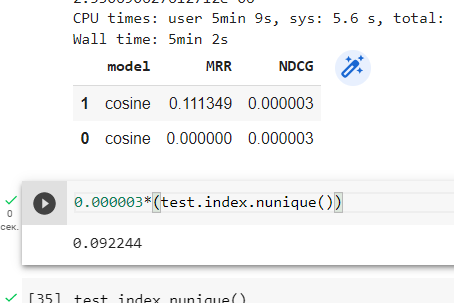

In [ ]:
0.000003*(test.index.nunique())

0.092244

In [ ]:
test.index.nunique()

30748

In [ ]:
%%time

compare_models = pd.DataFrame(columns = ["model", "MRR", "NDCG"])


for model_name, model in models.items():
    rec_df = get_recommenders(model, csr_train, test)
    compare_models.loc[-1] = [model_name]+[0]*(compare_models.shape[1]-1)
    compare_models.index = compare_models.index + 1

    for metric_name, metric in metrics.items():
        m = metric(test, rec_df)
        compare_models[metric_name] = m
        print(m)
compare_models

  0%|          | 0/161 [00:00<?, ?it/s]

0.11134873141833242
0.07781367541783567


  0%|          | 0/20 [00:00<?, ?it/s]

0.07145442160646337
0.048372951778578074
CPU times: user 9min 6s, sys: 33 s, total: 9min 39s
Wall time: 9min 18s


,model,MRR,NDCG
3,cosine,0.071454,0.048373
2,cosine,0.071454,0.048373
1,ALS,0.071454,0.048373
0,ALS,0.000000,0.048373


In [ ]:
test.index = test['user'].apply(lambda x: user2ind[x])

In [ ]:
from sklearn.metrics import ndcg_score
#ndcg = ndcg_score(test, df_reccom)

In [ ]:
df_reccom = df_reccom.explode(["ticker", "similar"])
df_reccom["rank"] = range(df_reccom.shape[0])
df_reccom["rank"] = df_reccom["rank"].apply(lambda x: x%10+1)

In [ ]:
MRR(test.reset_index().drop(["index"], 1), df_reccom)
rank = [1 + list(predict_data['ticker'][user]).index(x) for x in \
        set(predict_data['ticker'][user]).intersection(set(test_data['ticker'][user]))]

[1 + list(df_reccom['ticker'][36]).index(x) for x in \
                    set(df_reccom['ticker'][36]).intersection(set(test['ticker'][36]))]

In [ ]:
#(set(test['ticker'].filter(test.user_id == 4)))
for i in range(0, 100):
    s = set(df_reccom['ticker'][i]).intersection(test.loc[test.user_id == i]["ticker"])
    if len(s)!=0:
        print(i, s)

In [ ]:
set(df_reccom['ticker'][36]).intersection(set(test['ticker'][36]))

In [ ]:
set(test['ticker'][36])

In [ ]:
df_reccom

In [ ]:
test

In [ ]:
test = test.reset_index().drop(["index"], 1)
test.index = test['user'].apply(lambda x: user2ind[x])
test

In [ ]:
df_reccom.index

In [ ]:
rank = [1 + list(df_reccom['ticker'][df_reccom.user_id == 6]).index(x) for x in \
        set(df_reccom['ticker'][df_reccom.user_id == 6]).intersection(set(test['ticker'][df_reccom.user_id == 6]))]

In [ ]:
%%time
print(NDCG(test, df_reccom))

In [ ]:
k = [1, 2, 3]
b = [4, 5, 6]
c = [7, 8, 9]

for (i, d, f) in zip(k, b, c):
    print(i, d, f)